# Version information

In [21]:
from datetime import date
print("Running date:", date.today().strftime("%B %d, %Y"))
import pyleecan
print("Pyleecan version:" + pyleecan.__version__)
import SciDataTool
print("SciDataTool version:" + SciDataTool.__version__)
# %matplotlib notebook
# import matplotlib
# # matplotlib.use('Agg')
# matplotlib.use('Agg')

path = 'D:/NGV/Lecture_Simu_Model'
model = 'SIPMSM10p12_whole.json'
modelname = '10p12s'

Running date: July 05, 2022
Pyleecan version:1.3.9
SciDataTool version:2.4.8


# Force Module을 사용하여 자기력을 계산하는 방법

이 튜토리얼은 pyleecan으로 **자기력을 계산**하는 다양한 단계를 보여줍니다.

SciDataTool 개체의 기능과 사용법을 설명하기 위해 FEMM뮬레이션을 실행하고 전류를 인가하여 실행 시간을 줄이기 위해 주기성과 병렬연산을 사용합니다.

C:/Users/KDH2018-PC/anaconda3/envs/py38_pyleecan139/Lib/site-packages/pyleecan/Data


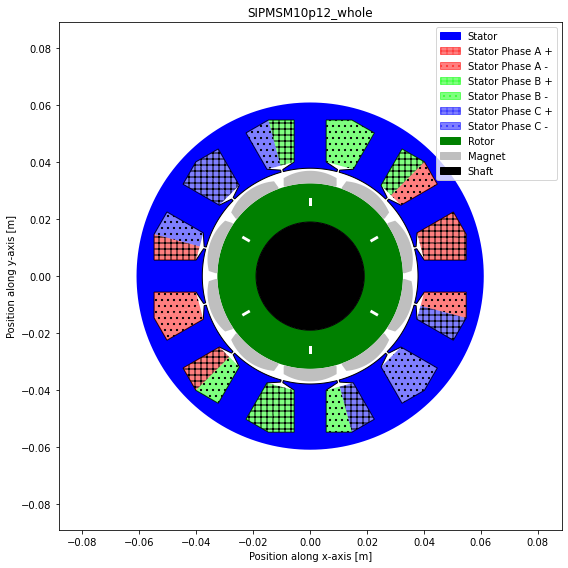

In [22]:
%matplotlib inline

# Load the machine
from os.path import join
from pyleecan.Functions.load import load
from pyleecan.definitions import DATA_DIR
print(DATA_DIR)


from os.path import join
from numpy import (
    zeros,
    exp,
    pi,
    real,
    meshgrid,
    mean,
)

# 힘 계산 클래스 추가
from pyleecan.Classes.ForceMT import ForceMT
from pyleecan.Classes.OPdq import OPdq
from pyleecan.Classes.Simu1 import Simu1
from pyleecan.Classes.MagFEMM import MagFEMM
from pyleecan.Classes.InputCurrent import InputCurrent


from pyleecan.Functions.load import load
from pyleecan.Functions.Plot import dict_2D, dict_3D 
from pyleecan.definitions import DATA_DIR   


# Load machine
# spm10p12s_sg = load(join(DATA_DIR,"Machine",model))
spm10p12s_sg = load(join(path,model))
spm10p12s_sg.plot()
Copper1 = load(join(DATA_DIR, "Material", "Copper1.json"))
Insu=load(join(DATA_DIR, "Material", "Insulator1.json"))
spm10p12s_sg.stator.winding.conductor.cond_mat=Copper1
spm10p12s_sg.stator.winding.conductor.ins_mat=Insu

c:\Users\KDH2018-PC\anaconda3\envs\py38_pyleecan_v1\lib\site-packages\pyleecan\Methods\Machine\LamSlotWind\plot.py:192: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


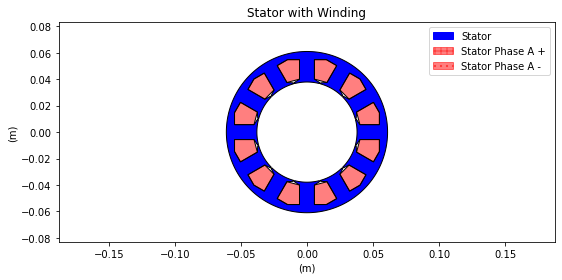

In [55]:
from pyleecan.Classes.LamSlotWind import LamSlotWind
from pyleecan.Classes.SlotW14 import SlotW14
from pyleecan.Classes.MachineUD import MachineUD
from pyleecan.Classes.LamSlot import LamSlot
from pyleecan.Classes.Winding import Winding

from numpy import pi



mm = 1e-3  # Millimeter

# Lamination setup
stator = LamSlotWind(
    Rext=61 * mm, # external radius [m] *외경
    Rint=37.9 * mm, # internal radius [m]  * 내경
    L1=63* mm, # Lamination stack active length [m] without radial ventilation airducts  *적층
                # but including insulation layers between lamination sheets
    Kf1=0.97, # Lamination stacking / packing factor *적층 계수
    Nrvd=0, # Number of radial air ventilation duct
    is_internal= False, # 요크의 위치
    is_stator=True, 
)

# Slot setup
stator.slot =  SlotW14(
    Zs=12, # Slot number
    W0=0.8 * mm,  # Slot isthmus width
    W3=11.3 * mm, # Slot bottom width
    H0=0.76 * mm,  # Slot isthmus height 폴슈 길이
    H1=1.52*mm, # 슬롯 높이
    H3=14.73 * mm, # Slot height below wedge 
)
stator.plot()

In [47]:
#from pyleecan.Classes.WindingDW1L import WindingDW1L
from pyleecan.Classes.Winding import Winding


from pyleecan.Classes.CondType12 import CondType12
# Winding setup
#stator.winding = WindingDW1L(
stator.winding = Winding(
    qs=3,  # number of phases
    Lewout=0,  # staight length of conductor outside lamination before EW-bend
    p=5,  # number of pole pairs
    Nlayer=2,
    coil_pitch=1,
    Ntcoil=55,  # number of turns per coil
    Npcp=2,  # number of parallel circuits per phase
    Nslot_shift_wind=0,  # 0 not to change the stator winding connection matrix built by pyleecan number 
                         # of slots to shift the coils obtained with pyleecan winding algorithm 
                         # (a, b, c becomes b, c, a with Nslot_shift_wind1=1)
    is_reverse_wind=False # True to reverse the default winding algorithm along the airgap 
                         # (c, b, a instead of a, b, c along the trigonometric direction)
)

# Conductor setup
stator.winding.conductor = CondType12(
        Wwire=1*mm,
        Wins_cond=1.1*mm,
        Nwppc=1,
        Wins_wire=0.05*mm,
        # Kwoh=0.5,
)
stator.plot()

NameError: name 'stator' is not defined

In [ ]:
from pyleecan.Classes.LamHole import LamHole

# Rotor setup
rotor = LamHole(
    Rint=55.32 * mm, # Internal radius
    Rext=80.2 * mm, # external radius
    is_internal=True, 
    is_stator=False,
    L1=stator.L1 # Lamination stack active length [m] 
                 # without radial ventilation airducts but including insulation layers between lamination sheets
)

## Simu 1 Simulation (No-load)

In [23]:
#  from Tests import save_validation_path as save_path
# Benchmark = load(join(DATA_DIR, "Machine", "Benchmark.json"))
# Benchmark.plot()
# simu1 = Simu1(name="AC_IPMSM_plot", machine=Benchmark)
simu1 = Simu1(name="spm10p12s_wh_noload", machine=spm10p12s_sg)
# print(spm10p12s_sg.stator)
# spm10p12s_sg.stator.notch=[]
# print(Benchmark.stator.notch)
# print(spm10p12s_sg.stator.notch)
# spm10p12s_sg.stator.mat_type.mag.plot_BH()
# Benchmark
# spm10p12s_sg
# spm10p12s_sg.stator.mat_type.path


In [28]:

simu1.input = InputCurrent(
    OP=OPdq(Id_ref=0, Iq_ref=0, N0=2000),
    Ir=None,
    Na_tot=5*2 ** 8, # angle 
    Nt_tot=2,
    # Nt_tot=2 ** 8, #Time
    # Nt_tot=2
)
# Prepare simulation
# simu = Simu1(name="AC_IPMSM_plot", machine=Benchmark)

# simu.input = InputCurrent(
#     Id_ref=0, Iq_ref=0, Ir=None, Na_tot=5 * 2 ** 8, Nt_tot=2, N0=1200
# )
simu1.elec = None


simu1.mag = MagFEMM(
    type_BH_stator=0,  # 0 to use the material B(H) curve, 
    type_BH_rotor=0,   # 0 to use the material B(H) curve, 
    is_periodicity_a=False,
    is_periodicity_t=False,
    # is_sliding_band=False,
    Kmesh_fineness=1,
    Kgeo_fineness=1,
)
simu1.force = ForceMT(
    is_periodicity_a=False,
    is_periodicity_t=False,
)


simu1.mag.is_get_meshsolution = True # To get FEA mesh for latter post-procesing
# simu1.mag.is

simu1.mag.nb_worker = 8



In [29]:
out_noload = simu1.run()
# AGSF_noload = out_noload.force.AGSF 


[20:25:06] Starting running simulation spm10p12s_wh_noload (machine=SIPMSM10p12_whole)
[20:25:06] Starting Magnetic module


AssertionError: 

c:\Users\KDH2018-PC\anaconda3\envs\py38_pyleecan139\lib\site-packages\SciDataTool\Functions\Plot\plot_2D.py:539: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
c:\Users\KDH2018-PC\anaconda3\envs\py38_pyleecan139\lib\site-packages\SciDataTool\Functions\Plot\plot_2D.py:539: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


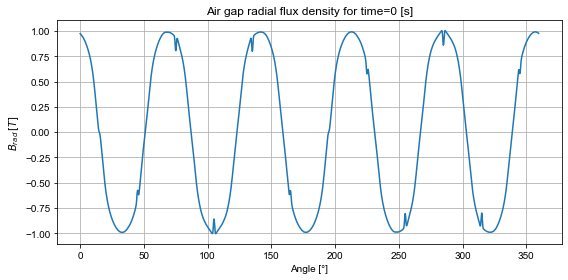

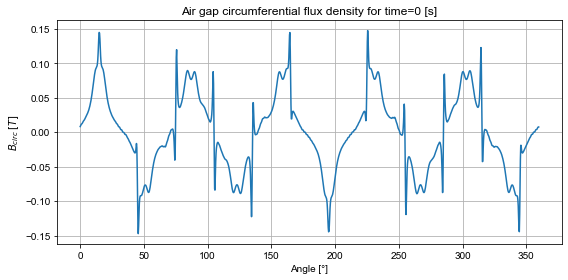

In [12]:
%matplotlib inline
out_noload.mag.B.plot_2D_Data("angle{°}")
# {°}

## Simu2 simulation (Load)


In [13]:
# 부하 해석

import math

simu2 = Simu1(name="spm10p12s_sg_load", machine=spm10p12s_sg)
N0=2000
# I0, Phi0 설정
I0_rms = 50.60/math.sqrt(2) # Maximum current [Arms]
Phi0 = 90*pi/180  # Maximum Torque Per Amp

# 해당 Id/Iq 계산
Id_ref = (I0_rms*exp(1j*Phi0)).real
Iq_ref = (I0_rms*exp(1j*Phi0)).imag

#정현파 전류의 정의 (OPdq)
simu2.input = InputCurrent(
    OP=OPdq(Id_ref=Id_ref, Iq_ref=Iq_ref, N0=N0),
    Ir=None,
    Na_tot=5*2 ** 8, # angle
    # Nt_tot=2 ** 8, #Time
    Nt_tot=120, #Time
)

simu2.elec = None

simu2.mag = MagFEMM(
    type_BH_stator=0,
    type_BH_rotor=0,
    is_periodicity_a=True,
    is_periodicity_t=True,
)
simu2.force = ForceMT(
    is_periodicity_a=True,
    is_periodicity_t=True,
)

simu2.mag.is_get_meshsolution = True # To get FEA mesh for latter post-procesing
simu2.mag.is_save_meshsolution_as_file = True # To save FEA results in a dat file


simu2.mag.nb_worker = 8
out_load = simu2.run()
AGSF_load = out_load.force.AGSF # data postcalculation





[17:42:07] Starting running simulation spm10p12s_sg_load (machine=SPM_10p12s_sg_rotor)
[17:42:07] Starting Magnetic module
[17:42:08] Computing Airgap Flux in FEMM
[17:43:39] Starting Force module
[17:43:39] End of simulation spm10p12s_sg_load


In [32]:
print(out_noload.mag.B.components['radial'])

parent = <class 'SciDataTool.Classes.VectorField.VectorField'> object
symbol = "B_{rad}"
name = "Air gap radial flux density"
unit = "T"
normalizations = dict()
axes = [<SciDataTool.Classes.DataLinspace.DataLinspace object at 0x000002EC66D687F0>, <SciDataTool.Classes.DataLinspace.DataLinspace object at 0x000002EC66D686A0>, <SciDataTool.Classes.DataPattern.DataPattern object at 0x000002EC66D68970>]

FTparameters = {}
values = 
[[[ 0.94466486]
  [ 0.94473106]
  [ 0.94490963]
  ...
  [-0.94672105]
  [-0.94582044]
  [-0.94501319]]

 [[-0.94466486]
  [-0.94473106]
  [-0.94490963]
  ...
  [ 0.94672105]
  [ 0.94582044]
  [ 0.94501319]]]

is_real = True



# Plot &  Data Check(Load) -3D Airgap Flux density (One rotation,Oneperiod, Smallestperiod)

c:\Users\KDH2018-PC\anaconda3\envs\py38_pyleecan139\lib\site-packages\SciDataTool\Functions\Plot\plot_3D.py:371: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


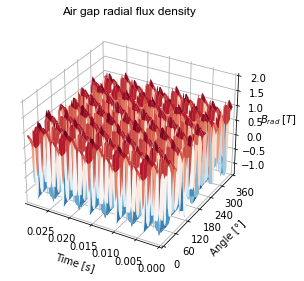

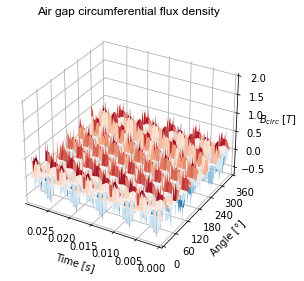

In [33]:
# 기계적 한주기 및 한바퀴 
out_load.mag.B.plot_3D_Data("time", "angle{°}", is_2D_view=False,z_max=2)

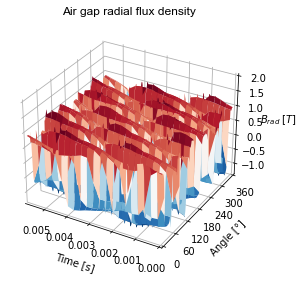

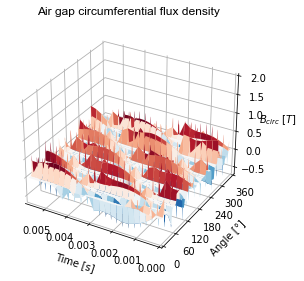

In [34]:
# 전기적 한주기
out_load.mag.B.plot_3D_Data("time[oneperiod]", "angle[oneperiod]{°}", is_2D_view=False,z_max=2)

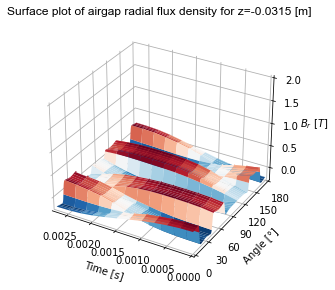

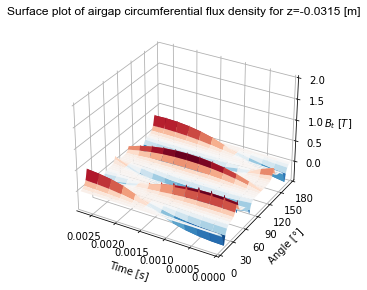

In [24]:
# 전기적 1/2 주기 (최소)
out_load.mag.B.plot_3D_Data("time[smallestperiod]", "angle[smallestperiod]{°}", is_2D_view=False, z_max=2)

## Data check(Load) 공간 자속밀도분포(공극) 

c:\Users\KDH2018-PC\anaconda3\envs\py38_pyleecan139\lib\site-packages\SciDataTool\Functions\Plot\plot_2D.py:539: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


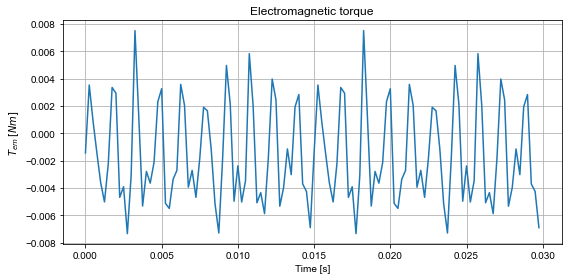

In [42]:
# out_load.mag.Tem.plot_2D_Data('time')
out_noload.mag.Tem.plot_2D_Data('time')

### Spatial Distribution

c:\Users\KDH2018-PC\anaconda3\envs\py38_pyleecan139\lib\site-packages\SciDataTool\Functions\Plot\plot_2D.py:539: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
c:\Users\KDH2018-PC\anaconda3\envs\py38_pyleecan139\lib\site-packages\SciDataTool\Functions\Plot\plot_2D.py:539: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


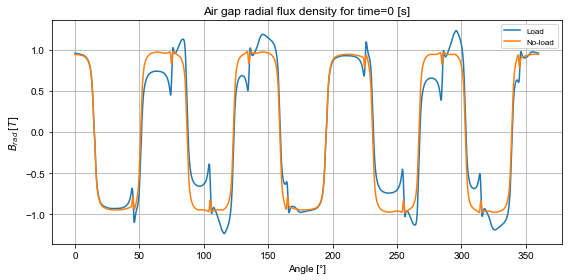

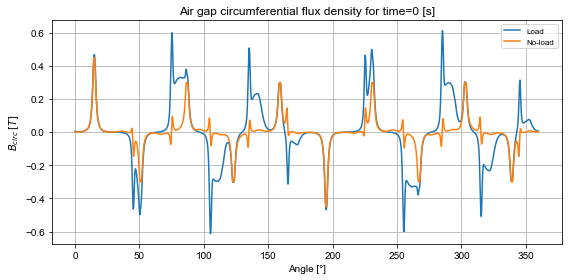

In [35]:
# 공간적 자속 밀도 분포도 비교
out_load.mag.B.plot_2D_Data("angle{°}",data_list=[out_noload.mag.B],legend_list=['Load','No-load'])

### Temporal Distribution

c:\Users\KDH2018-PC\anaconda3\envs\py38_pyleecan_v1\lib\site-packages\SciDataTool\Functions\Plot\plot_2D.py:443: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
c:\Users\KDH2018-PC\anaconda3\envs\py38_pyleecan_v1\lib\site-packages\SciDataTool\Functions\Plot\plot_2D.py:443: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


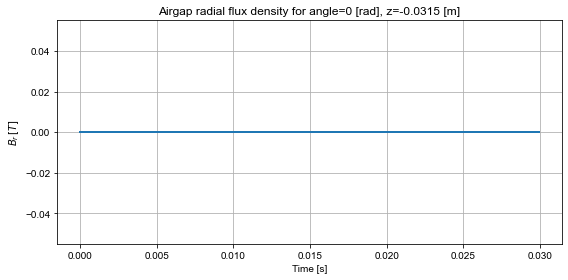

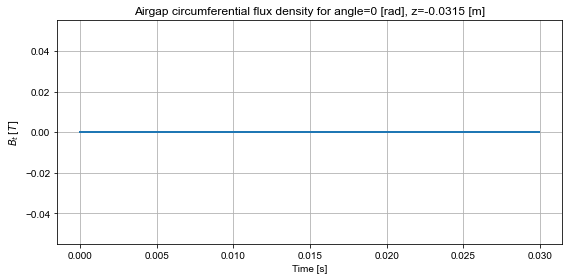

In [8]:
# 시간적 자속 밀도 분포도 비교
# out_load.mag.B.plot_2D_Data("time",data_list=[out_noload.mag.B],legend_list=['Load','No-load'])


## FFT of B

#### 1D FFT

Rotating frequency f_mech 33.333333333333336 Hz
Mechanical temporal order : H
Number of freqs_B_r: 13
Temporal Frequency freq_in_mech= [   0.          166.66666667  333.33333333  500.          666.66666667
  833.33333333 1000.         1166.66666667 1333.33333333 1500.
 1666.66666667 1833.33333333 2000.        ]
Number of wavenumber: 1280
Wavenumber r=: [-640. -639. -638. ...  637.  638.  639.]


c:\Users\KDH2018-PC\anaconda3\envs\py38_pyleecan_v1\lib\site-packages\SciDataTool\Functions\Plot\plot_2D.py:443: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


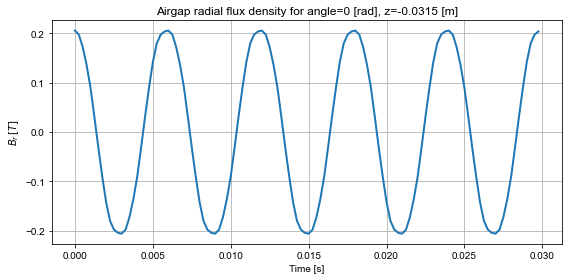

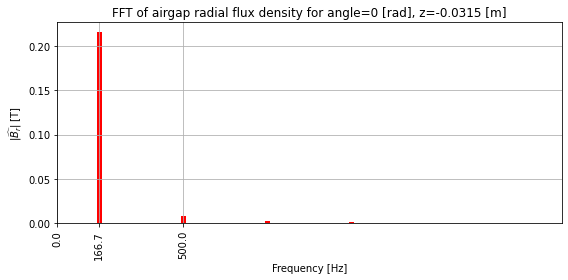

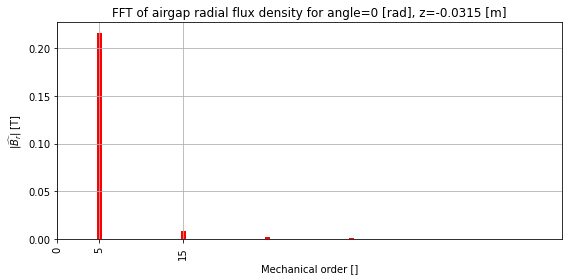

In [27]:
# 원하는 주파수 대역을 확인하기 위한 최소 스텝 확인
# 시간적 전자기력 밀도확인

rpm=2000
poles=10

#기계적 주파수
print('Rotating frequency f_mech', 2000/60, 'Hz')
out_load.mag.B.plot_2D_Data("time", component_list=["radial"])
out_load.mag.B.plot_2D_Data("freqs=[0,6e3]", component_list=["radial"], **dict_2D)

# 원하는 주파수 대역을 확인하기 위한 최소 스텝 확인
print('Mechanical temporal order : H')
out_load.mag.B.plot_2D_Data("freqs->mech_order=[0,200]", component_list=["radial"], **dict_2D)

# Check time-space reconstruction

arg_list = ["freqs", "wavenumber", "mech_order"]
result = out_load.mag.B.get_rphiz_along(*arg_list)
result_freq = out_load.mag.B.get_rphiz_along(*arg_list)

B_r_freq = result_freq["radial"]
freqs_B_r = result_freq["freqs"]
wavenumber_B_r = result_freq["wavenumber"]
Nf = len(freqs_B_r)
Nr = len(wavenumber_B_r)

print('Number of freqs_B_r:',Nf)
print('Temporal Frequency freq_in_mech=',freqs_B_r)
print('Number of wavenumber:',Nr)
print('Wavenumber r=:',wavenumber_B_r) # number of Wavenumber should be half of spatial data from Nyquist Theorem 

c:\Users\KDH2018-PC\anaconda3\envs\py38_pyleecan_v1\lib\site-packages\SciDataTool\Functions\Plot\plot_2D.py:443: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


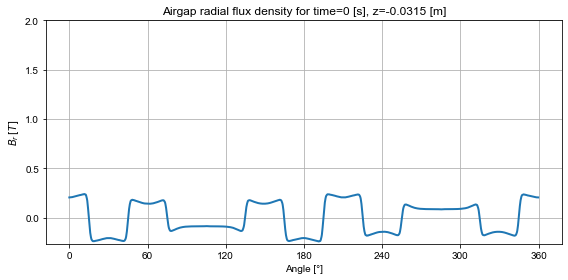

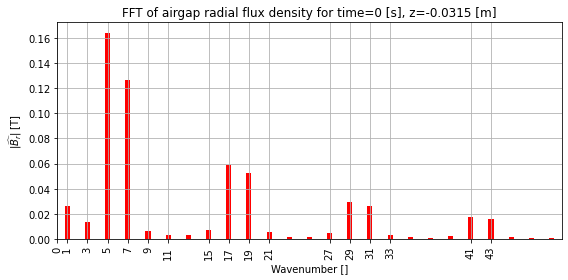

In [28]:
# 방사방향 자속 밀도 공간적 FFT
out_load.mag.B.plot_2D_Data("angle{°}", component_list=["radial"],y_max=2)
out_load.mag.B.plot_2D_Data("wavenumber=[0,50]", component_list=["radial"], **dict_2D)

#### 2D FFT(3D view)

c:\Users\KDH2018-PC\anaconda3\envs\py38_pyleecan_v1\lib\site-packages\SciDataTool\Functions\Plot\plot_3D.py:354: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
c:\Users\KDH2018-PC\anaconda3\envs\py38_pyleecan_v1\lib\site-packages\SciDataTool\Functions\Plot\plot_4D.py:271: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


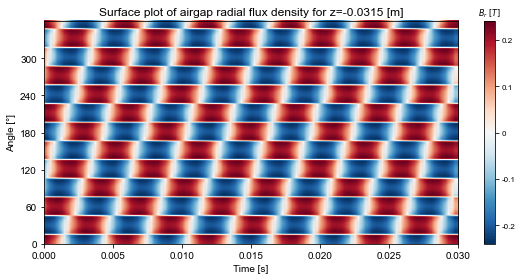

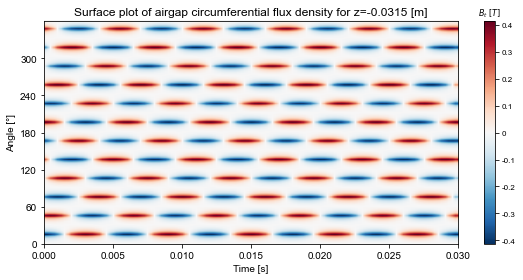

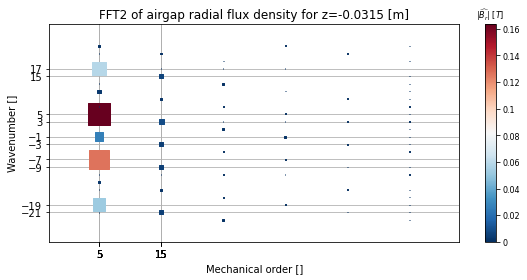

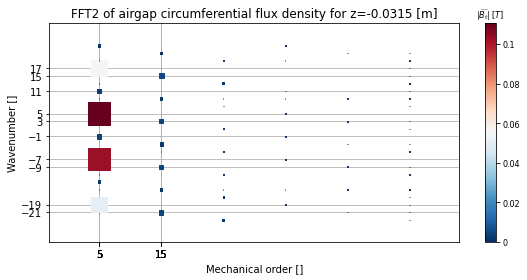

In [29]:
# Angle/Time → WaveNumber/mech_order

out_load.mag.B.plot_3D_Data("time", "angle{°}", is_2D_view=True,x_max=0.03)

out_load.mag.B.plot_3D_Data(
    "freqs->mech_order=[0,96]",
    "wavenumber=[-24,24]",
    N_stem=100,
   
    component_list=["radial"],
    is_2D_view=True,
    **dict_3D
)

out_load.mag.B.plot_3D_Data(
    "freqs->mech_order=[0,96]",
    "wavenumber=[-24,24]",
    N_stem=100,
   
    component_list=["tangential"],
    is_2D_view=True,
    **dict_3D
)


# Plot & Data Check Electromagnetic Force Density[P]


Force 추상 클래스를 사용하면 힘을 계산하는 다양한 방법을 정의할 수 있습니다.

ForceMT 클래스는 Force 클래스에서 상속됩니다. ForceMT는 Maxwell 응력 텐서 \[[source](https://eomys.com/IMG/pdf/comparison-main-magnetic.pdf)\]를 기반으로 하는 공극 표면력을 계산합니다.

여기서 우리는 힘 계산 없이 자기 시뮬레이션의 결과를 얻습니다. Force 모듈은 초기화되고 단독으로 실행됩니다.
시뮬레이션이 완료되면 결과가 출력의 force 부분(예: _myResults.force_ )에 저장되고 다른 플롯을 호출할 수 있습니다. 이 개체에는 다음이 포함됩니다.
- *시간*: 시간 축
- *각도*: 각도 위치 축
- *AGSF*: 에어갭 표면력(방사형 및 접선 성분)
    
**출력** 개체는 결과를 쉽게 시각화하기 위해 다른 플롯을 포함합니다. 

## Data check(Load vs No load)


In [30]:
# 자속밀도를 통해 전자기력 밀도 계산 (매트랩 실습)

out_dict=dict()
Rag=out_load.mag.Rag
out_dict['Rag']=Rag

output=simu2.force.parent.parent
axes_dict=simu2.force.comp_axes(output)

#시간축과 공간축 정의
Angle = axes_dict["angle"]
Time = axes_dict["time"]

#공간축 벡터 
is_periodicity_a, is_antiper_a = Angle.get_periodicity()
angle = Angle.get_values(
    is_oneperiod=is_periodicity_a,
    is_antiperiod=is_antiper_a and is_periodicity_a,
)


#시간축 벡터
is_periodicity_t, is_antiper_t = Time.get_periodicity()
time = Time.get_values(
    is_oneperiod=is_periodicity_t,
    is_antiperiod=is_antiper_t and is_periodicity_t,
)


#자속밀도 불러오기
Brphiz = output.mag.B.get_rphiz_along(
    "time=axis_data",
    "angle=axis_data",
    axis_data={"time": time, "angle": angle},
)

Br = Brphiz["radial"]
Bt = Brphiz["tangential"]
# Bz = Brphiz["axial"]


#공기 투자율
mu_0 = 4 * pi * 1e-7

# 2차원
out_dict["AGSF_r"] = -(Br * Br - Bt * Bt) / (2 * mu_0)
out_dict["AGSF_t"] = -Br * Bt / mu_0

print(Br)
print(Bt)
print(out_dict)
# C:\Users\TH\anaconda3\envs\py38_pyleecan\Lib\site-packages\pyleecan\Results\IPMSM_AGSF_spectrum_load\Femm

[[ 0.20580861  0.20616429  0.20658392 ... -0.20602133 -0.20616773
  -0.20596936]
 [ 0.19778237  0.19815966  0.1985713  ... -0.1977176  -0.19786923
  -0.19779271]
 [ 0.17241628  0.17273986  0.17309167 ... -0.17199275 -0.17213689
  -0.17224553]
 ...
 [-0.17961789 -0.17966064 -0.17977375 ...  0.18022363  0.18005336
   0.17980353]
 [-0.19754222 -0.19769739 -0.19790728 ...  0.19802347  0.19795451
   0.19771387]
 [-0.20405377 -0.20431098 -0.20462312 ...  0.20441981  0.20445816
   0.20422886]]
[[-0.00136949 -0.00244403 -0.00354076 ... -0.00182145 -0.00075157
   0.00030795]
 [-0.00227111 -0.00321671 -0.00418855 ... -0.00048496  0.00042939
   0.00134453]
 [-0.00312775 -0.00387094 -0.00464726 ...  0.00103785  0.0017209
   0.00241403]
 ...
 [-0.00106521 -0.00013955  0.000784   ...  0.0039483   0.00296054
   0.00200253]
 [-0.00026265  0.00079757  0.00186634 ...  0.0035149   0.00240617
   0.0013261 ]
 [ 0.00052466  0.00163625  0.00276564 ...  0.00283171  0.001696
   0.00058128]]
{'Rag': 0.036199999

c:\Users\KDH2018-PC\anaconda3\envs\py38_pyleecan_v1\lib\site-packages\SciDataTool\Functions\Plot\plot_2D.py:443: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
c:\Users\KDH2018-PC\anaconda3\envs\py38_pyleecan_v1\lib\site-packages\SciDataTool\Functions\Plot\plot_2D.py:443: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
c:\Users\KDH2018-PC\anaconda3\envs\py38_pyleecan_v1\lib\site-packages\SciDataTool\Functions\Plot\plot_2D.py:443: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
c:\Users\KDH2018-PC\anaconda3\envs\py38_pyleecan_v1\lib\site-packages\SciDataTool\Functions\Plot\plot_2D.py:443: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, 

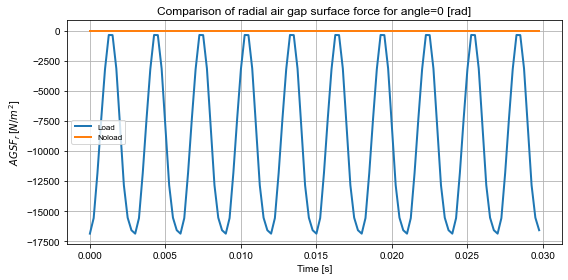

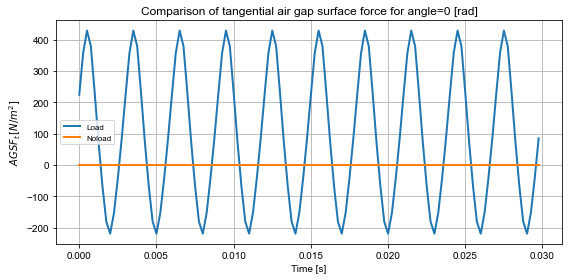

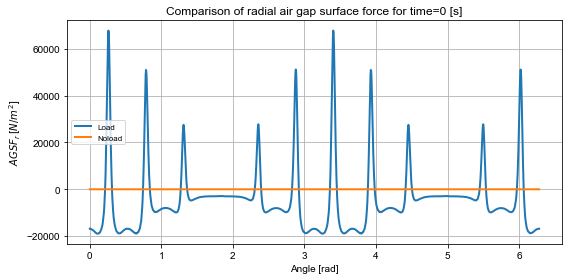

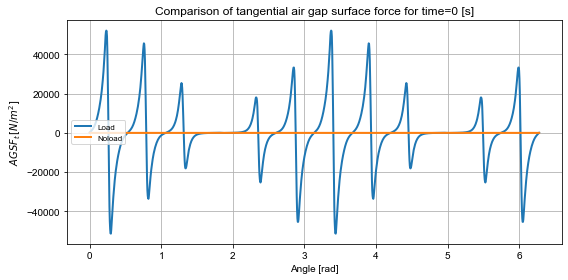

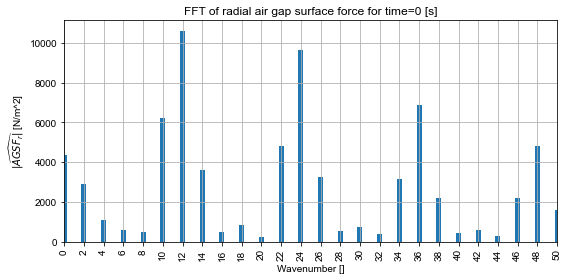

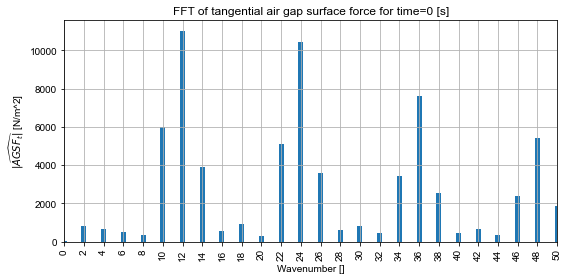

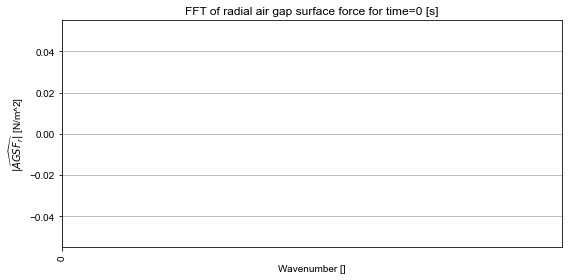

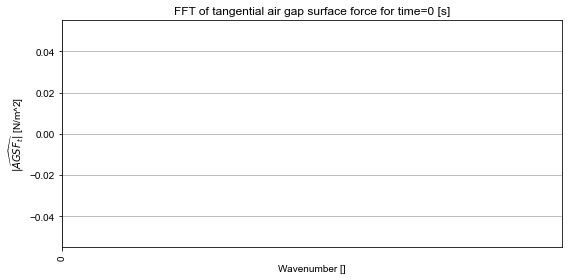

In [31]:
# 부하 무부하 해석 결과 비교

AGSF_load.plot_2D_Data(
    "time", component_list=["radial"], data_list=[AGSF_noload], legend_list=["Load", "Noload"],is_auto_range=False
)
#---------------------------------------------------------------
AGSF_load.plot_2D_Data(
    "time", component_list=["tangential"], data_list=[AGSF_noload], legend_list=["Load", "Noload"]
)


#---------------------------------------------------------------
# compare load and noload
AGSF_load.plot_2D_Data(
    "angle", component_list=["radial"], data_list=[AGSF_noload], legend_list=["Load", "Noload"],is_auto_range=False
)
#---------------------------------------------------------------
AGSF_load.plot_2D_Data(
    "angle", component_list=["tangential"], data_list=[AGSF_noload], legend_list=["Load", "Noload"]
)


AGSF_load.plot_2D_Data(
    "wavenumber=[0,50]",
    component_list=["radial"],
)

AGSF_load.plot_2D_Data(
    "wavenumber=[0,50]",
    component_list=["tangential"],
)

AGSF_noload.plot_2D_Data(
    "wavenumber=[0,50]",
    component_list=["radial"],
)

AGSF_noload.plot_2D_Data(
    "wavenumber=[0,50]",
    component_list=["tangential"],
)




c:\Users\KDH2018-PC\anaconda3\envs\py38_pyleecan_v1\lib\site-packages\SciDataTool\Functions\Plot\plot_3D.py:354: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


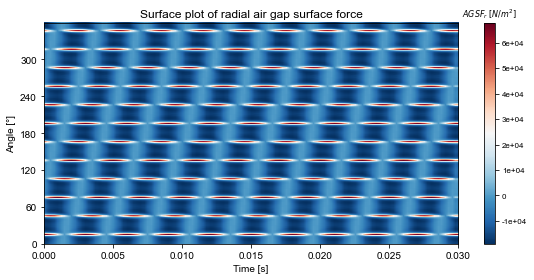

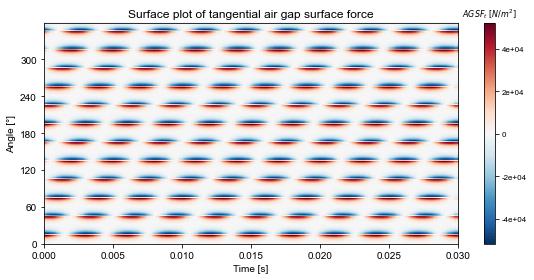

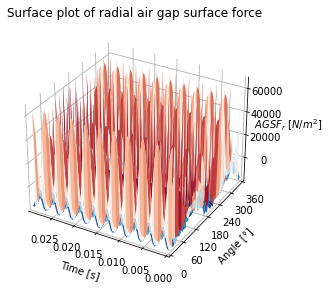

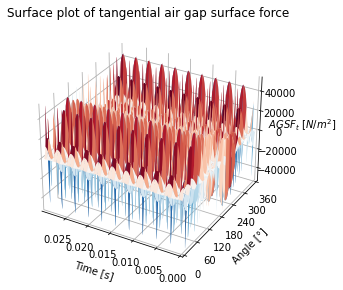

In [32]:
# Force 확인 - 부하해석 결과 2D (Angle / Time)

AGSF_load.plot_3D_Data("time", "angle{°}", is_2D_view=True,x_max=0.03)
AGSF_load.plot_3D_Data("time", "angle{°}", is_2D_view=False, **dict_3D)

#------------------------------------------------------



c:\Users\KDH2018-PC\anaconda3\envs\py38_pyleecan_v1\lib\site-packages\SciDataTool\Functions\Plot\plot_3D.py:199: UserWarning: Attempting to set identical bottom == top == -0.0 results in singular transformations; automatically expanding.
  ax.set_zlim3d(z_min, z_max)


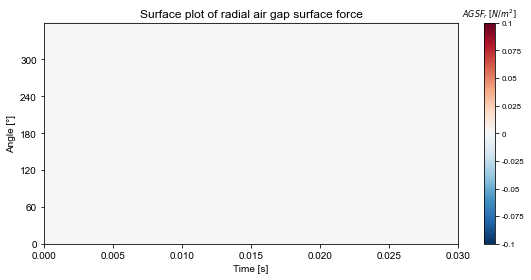

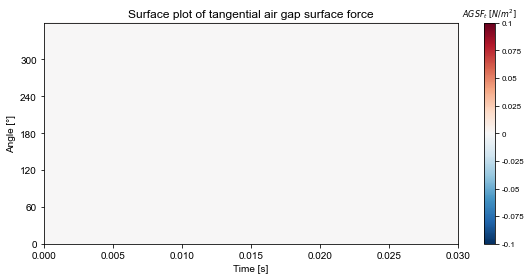

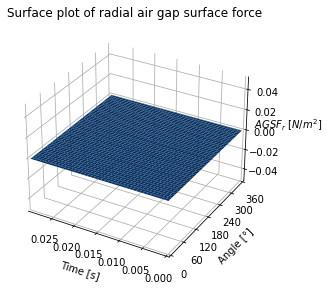

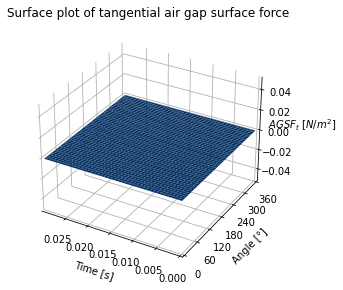

In [33]:
# 무부하 해석 결과 2D (Angle / Time)

AGSF_noload.plot_3D_Data("time", "angle{°}", is_2D_view=True,x_max=0.03)
AGSF_noload.plot_3D_Data("time", "angle{°}", is_2D_view=False, **dict_3D)


#------------------------------------------------------

## FFT of P

### 2D FFT

c:\Users\KDH2018-PC\anaconda3\envs\py38_pyleecan_v1\lib\site-packages\SciDataTool\Functions\Plot\plot_4D.py:271: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


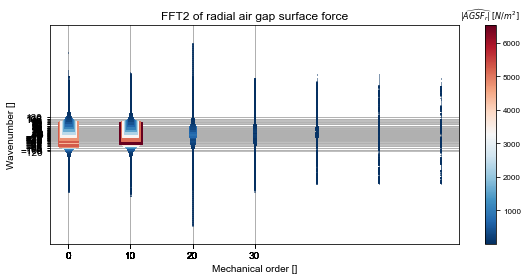

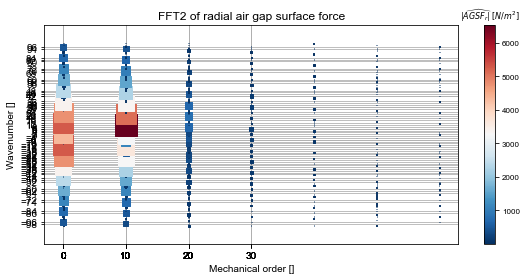

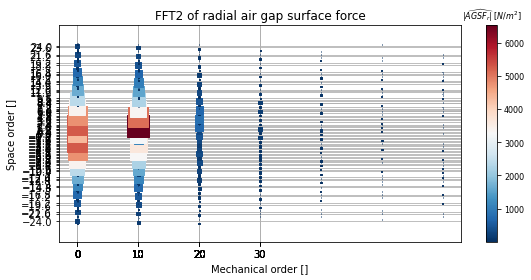

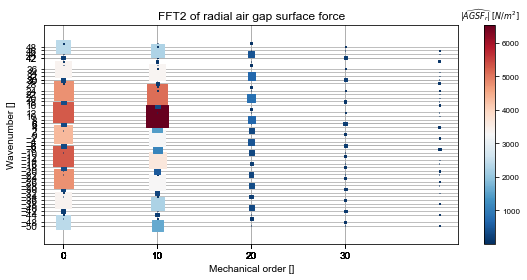

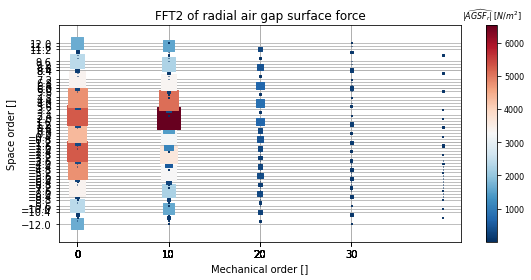

In [34]:
# 방사방향 전체 파형 2D (Mech_order / wavenumber)

AGSF_load.plot_3D_Data(
    "freqs->mech_order",
    "wavenumber",
    N_stem=100,
    component_list=["radial"],
    is_2D_view=True,
#     **dict_3D
)

# mech_order - wavenumber
AGSF_load.plot_3D_Data(
    "freqs->mech_order=[0,96]",
    "wavenumber=[-100,100]",
    N_stem=100,
    component_list=["radial"],
    is_2D_view=True,
#     **dict_3D
)

# mech_order - space_order
AGSF_load.plot_3D_Data(
    "freqs->mech_order=[0,96]",
    "wavenumber->space_order=[-25,25]",
    N_stem=100,
    component_list=["radial"],
    is_2D_view=True,
    **dict_3D

)

# mech_order - wavenumber
AGSF_load.plot_3D_Data(
    "freqs->mech_order=[0,48]",
    "wavenumber=[-50,50]",
    N_stem=100,
    component_list=["radial"],
    is_2D_view=True,
#     **dict_3D
)

# mech_order - space_order
AGSF_load.plot_3D_Data(
    "freqs->mech_order=[0,48]",
    "wavenumber->space_order=[-12,12]",
    N_stem=100,
    component_list=["radial"],
    is_2D_view=True,
    **dict_3D

)



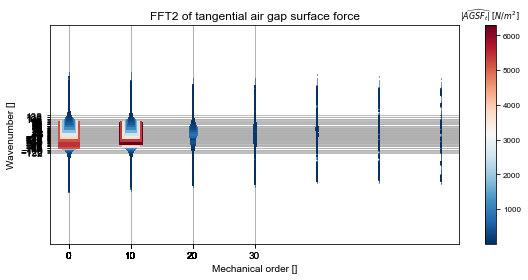

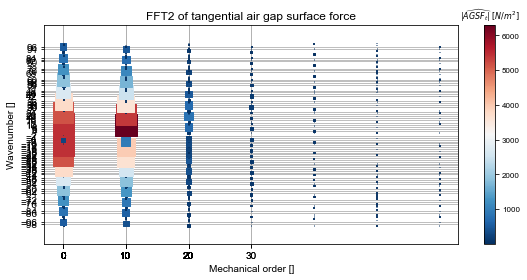

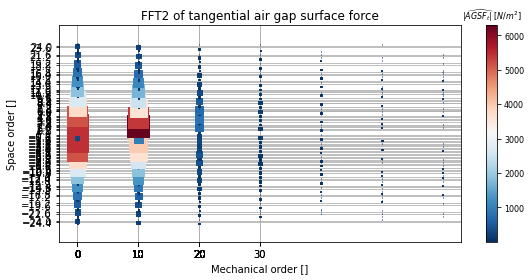

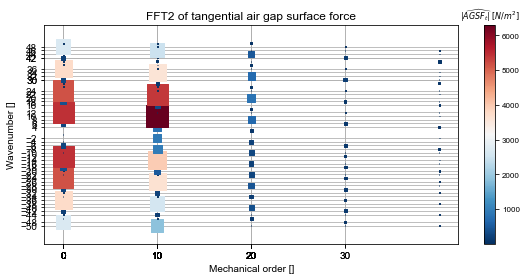

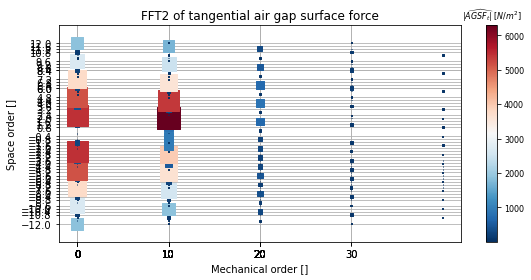

In [35]:
# 접선방향 전체 파형 2D (Mech_order / wavenumber)
AGSF_load.plot_3D_Data(
    "freqs->mech_order",
    "wavenumber",
    N_stem=100,
    component_list=["tangential"],
    is_2D_view=True,
#     **dict_3D
)

# mech_order - wavenumber
AGSF_load.plot_3D_Data(
    "freqs->mech_order=[0,96]",
    "wavenumber=[-100,100]",
    N_stem=100,
    component_list=["tangential"],
    is_2D_view=True,
#     **dict_3D
)

# mech_order - space_order
AGSF_load.plot_3D_Data(
    "freqs->mech_order=[0,96]",
    "wavenumber->space_order=[-25,25]",
    N_stem=100,
    component_list=["tangential"],
    is_2D_view=True,
    **dict_3D

)

# mech_order - wavenumber
AGSF_load.plot_3D_Data(
    "freqs->mech_order=[0,48]",
    "wavenumber=[-50,50]",
    N_stem=100,
    component_list=["tangential"],
    is_2D_view=True,
#     **dict_3D
)

# mech_order - space_order
AGSF_load.plot_3D_Data(
    "freqs->mech_order=[0,48]",
    "wavenumber->space_order=[-12,12]",
    N_stem=100,
    component_list=["tangential"],
    is_2D_view=True,
    **dict_3D

)



다음 플롯은 시간과 각도에 따른 방사형 에어 갭 표면력을 표시합니다.

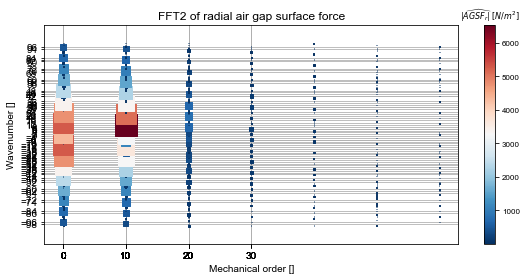

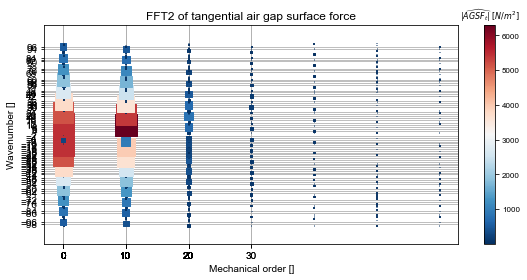

In [36]:
# 방사 방향 및 접선방향 AGSF 비교

# 방사방향 mech_order - wavenumber
AGSF_load.plot_3D_Data(
    "freqs->mech_order=[0,96]",
    "wavenumber=[-100,100]",
    N_stem=100,
    component_list=["radial"],
    is_2D_view=True,
#     **dict_3D
)

# 접선 방향 mech_order - wavenumber
AGSF_load.plot_3D_Data(
    "freqs->mech_order=[0,96]",
    "wavenumber=[-100,100]",
    N_stem=100,
    component_list=["tangential"],
    is_2D_view=True,
#     **dict_3D
)

#------------------------------------------------------

# Force vs Torque

c:\Users\KDH2018-PC\anaconda3\envs\py38_pyleecan_v1\lib\site-packages\SciDataTool\Functions\Plot\plot_2D.py:443: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
c:\Users\KDH2018-PC\anaconda3\envs\py38_pyleecan_v1\lib\site-packages\SciDataTool\Functions\Plot\plot_4D.py:271: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


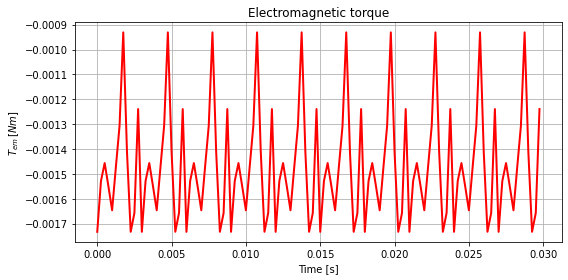

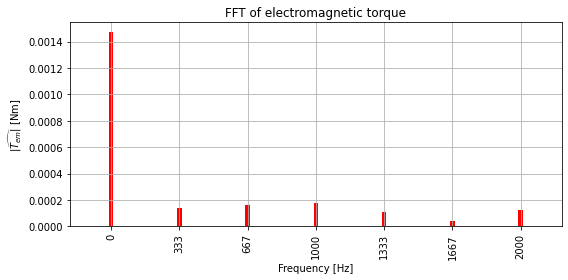

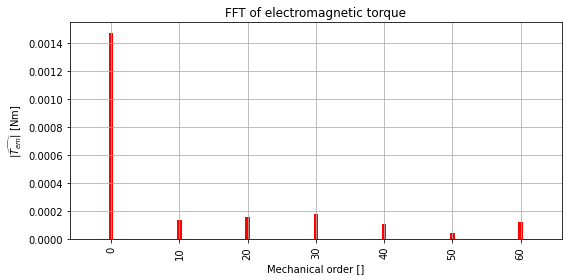

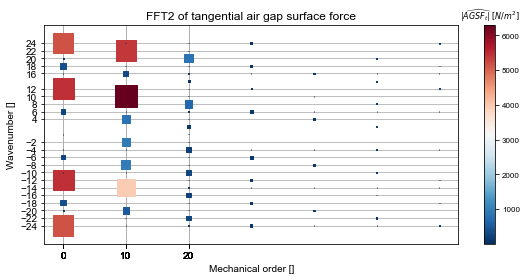

In [37]:
# 토크 파형
out_load.mag.Tem.plot_2D_Data("time", **dict_2D)

# 토크 파형 FFT
out_load.mag.Tem.plot_2D_Data("freqs", **dict_2D)
out_load.mag.Tem.plot_2D_Data("freqs->mech_order=[-48,96]", **dict_2D)

# AGSF
AGSF_load.plot_3D_Data(
    "freqs->mech_order=[0,96]",
    "wavenumber=[-24,24]",
    N_stem=100,
    component_list=["tangential"],
    is_2D_view=True,
)

